### Class & Module Imports

In [1]:
# - Module WAXS Classes
from WAXSAnalyze import WAXSAnalyze
from WAXSTransform import WAXSTransform
from WAXSDiffSim import WAXSDiffSim
# from WAXSExperiment import WAXSExperiment

# - Import Relevant Modules
import xarray as xr
import numpy as np
import pathlib

## WAXSAnalyze Project Example
#### How to create a new project for WAXS data analysis using the WAXSAnalyze class:

#### Setup DataPaths & Metadata Keys Example

In [2]:
# -- Core Path Definitions -- #
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
calibPath = basePath.joinpath('calib_files/ponimask')
dataPath = basePath.joinpath('data_files')

# -- Project Specific Paths -- #
# - March 2023 @ 11-BM (CMS)
poniPath = calibPath.joinpath('may23/may23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni')
maskPath = calibPath.joinpath('may23/may23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf')
zarrPath = basePath.joinpath('output_files/zarr_files')

# - June 2023 @ 11-BM (CMS)
# poniPath = calibPath.joinpath('jun23/jun23_poni_01_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni')
# maskPath = calibPath.joinpath('jun23/jun23_nslsii11bmcms_WAXS2pil1M_mask_03.edf')

# -- TIFF Path & Corresponding Metadata Keylist -- #
# Look at your filename, each '_' delimiter spaces out two keys. Add one key for each position in the filename.
metadata_keylist = ['samplenum', 
                    'chemistry', 
                    'filter', 
                    'concentration', 
                    'purge_rate', 
                    'substrate', 
                    'solution_volume', 
                    'runnum', 
                    'clocktime', 
                    'xpos', 
                    'thpos', 
                    'exptime', 
                    'scanID', 
                    'framenum', 
                    'detext']

tiffPath = dataPath.joinpath('sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs.tiff')
# tiffPath = dataPath.joinpath('/Users/keithwhite/github_repositories/pyWAXS/examples/data_files/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs.tiff')

#### Create a WAXSAnalyze Project Instance Example
##### WAXSAnalyze is the class name. waxs_analysis is this instance, or single instantiation, of the class. You can change this name 'waxs_analysis' to whatever you want, but you have to use that throughout when trying to reference that instance.

In [3]:
# - WAXSAnalyze Class Instantiation
from WAXSAnalyze import WAXSAnalyze

waxs_analysis = WAXSAnalyze(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=tiffPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)


##### Notice how we loaded all of the following: image correction file references, the X-ray energy, and the data?

Assuming your file has the incidence angle in the sample name, we can generate accurately corrected images. You can now access the reciprocal space image corrections and caked image corrections:

Reciprocal Space Map:
```python
waxs_analysis.reciptiff_xr
```

Caked Image:
```python
waxs_analysis.cakedtiff_xr
```

In [4]:
waxs_analysis.reciptiff_xr

<xarray.DataArray (q_z: 1043, q_xy: 981)>
array([[4.72308  , 2.777009 , 3.7451723, ..., 0.       , 0.       ,
        0.       ],
       [5.001747 , 2.9890037, 4.188971 , ..., 0.       , 0.       ,
        0.       ],
       [7.093914 , 4.5721583, 7.490466 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)
Coordinates:
  * q_z      (q_z) float64 0.02624 0.02892 0.03161 0.03429 ... 2.818 2.82 2.823
  * q_xy     (q_xy) float64 -2.431 -2.426 -2.421 -2.417 ... 2.038 2.043 2.047
Attributes: (12/16)
    samplenum:        sam22
    chemistry:        1MAI1PbI2
    filter:           unfilt
    concentration:    0p3M
    purge_rate:       5p0scfh
    substrate:        Si
    ...               ...
    thpos:            th0.300
    exptime:          0.49s
    scanID:           986546
    framenum:         001639
    detext:           maxs
    snr:              nan

##### Note how we had to use the syntax:
```python
waxs_analysis.
```
##### to access the the data.
This is how we access the instance that refers to your analysis project. You can have multiple instances coexist in the same notebook.

Now, click the 'Attributes' dropdown above. We loaded the data into an XArray DataArray (DA). 
##### All of the keys listed above in the setup were used to extract your metadata from the filename.

#### Image Plotting Example (Caked Image)

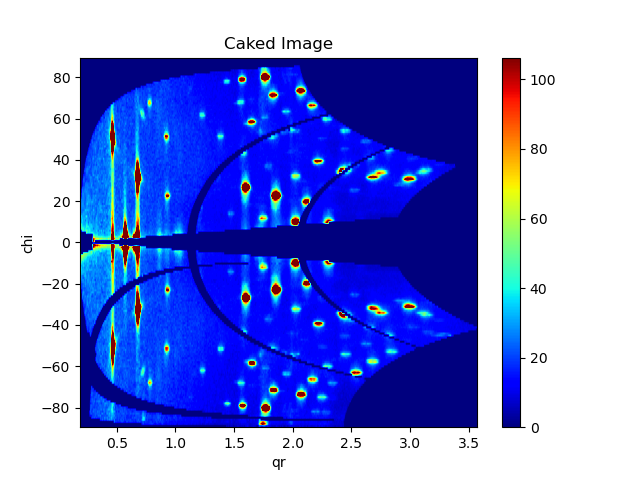

In [5]:
%matplotlib widget

# -- Display the Caked Image
# waxs_analysis.cakeddisplay_xr() # method 1

# waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, # method 2
waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, 
                            title='Caked Image', 
                            cmap='jet')

##### You can plot the data stored as attributes with one of a set of built-in methods, or a generalized method.

Custom Method (Caked Image):
```python
waxs_analysis.cakeddisplay_xr()
```
General Method Equivalent:
```python
waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, 
                            title='Caked Image', 
                            cmap='jet')
```

#### Image Intensity Correction (sin(chi)) Example

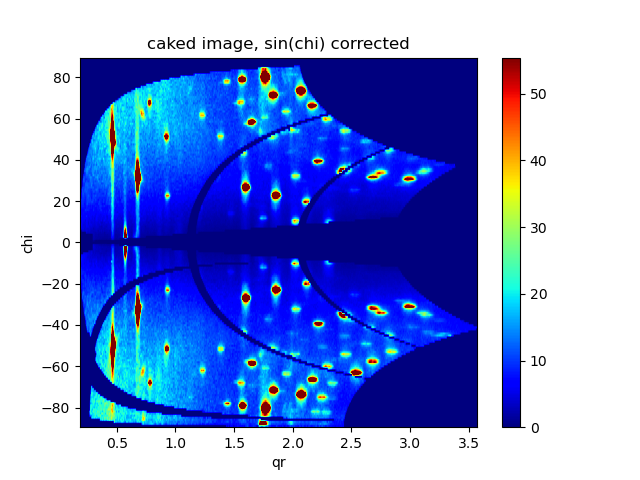

In [15]:
%matplotlib widget

cakedtiff_sinchi_xr = waxs_analysis.sinchi_corr(chicorr = True, 
                                                qsqr = False)

waxs_analysis.display_image(waxs_analysis.cakedtiff_sinchi_xr, 
                            title='caked image, sin(chi) corrected', 
                            cmap='jet')

#### Image Normalization Example (Caked Corrected Image)

Maximum Intensity Pixel Coordinate:  x:  0.4636632955036596 y:  -51.49999311566354


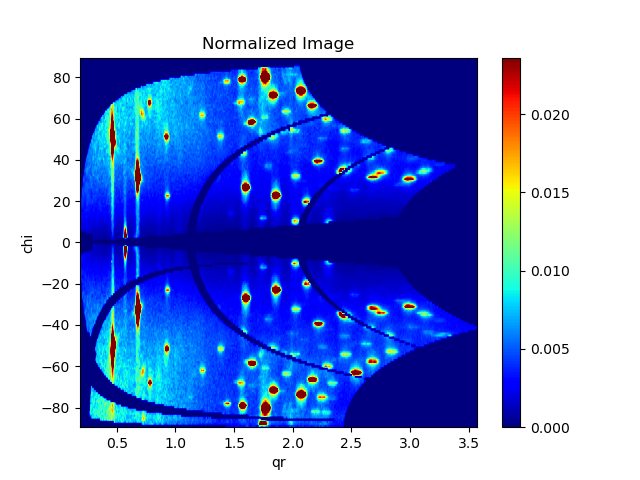

In [16]:
%matplotlib widget

# Generate the normalized reciprocal space map image
cakedtiff_xr_norm, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_sinchi_xr, 
                                                  normalizerecip=False)

# Check if the returned image is None or not of a compatible type
if cakedtiff_xr_norm is None or not isinstance(cakedtiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

print ('Maximum Intensity Pixel Coordinate: ', 'x: ', max_x, 'y: ', max_y)

# Display the normalized image
waxs_analysis.display_image(cakedtiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


#### Image Smoothing Example (Caked Image)

#### Image Peak Search Example (Caked Image)

#### Image Interpolation Example (Caked Image)

## Additional Examples

#### Normalize Image (Reciprocal Space Map)

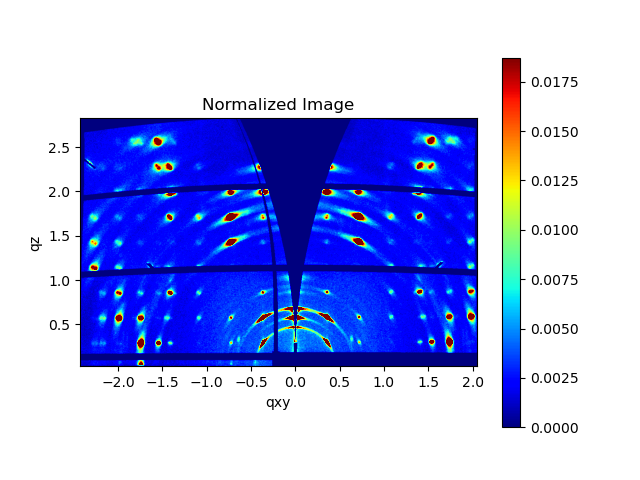

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


#### Normalize Image (Reciprocal Space Map)

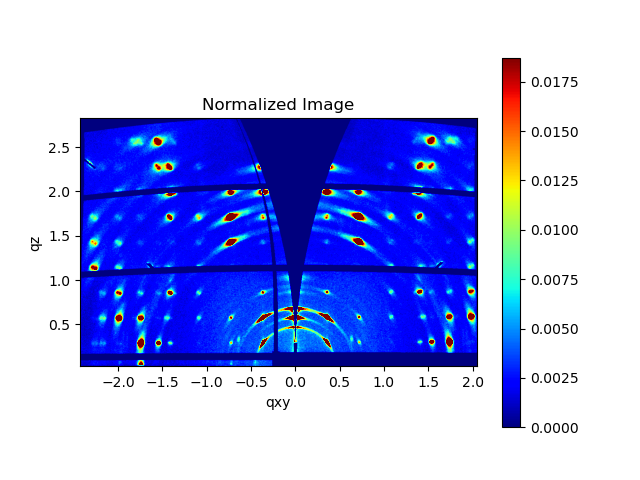

In [6]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


#### Interpolate Image

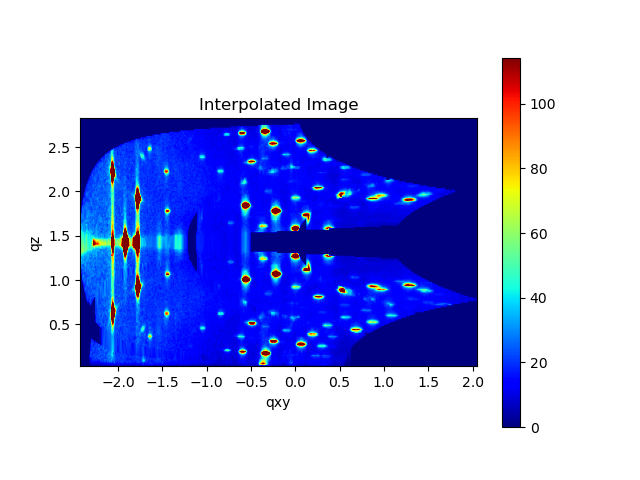

In [11]:
%matplotlib widget

cakedtiff_xr_interp = waxs_analysis.brute_force_interpolate(waxs_analysis.cakedtiff_xr, gap_threshold = 12)

# Display the normalized image
waxs_analysis.display_image(cakedtiff_xr_interp, 
                            title='Interpolated Image', 
                            cmap='jet')

# What about alternating row/column with linearly increasing gap_threshold size?
# Or a row/column average process?

#### Normalize Image

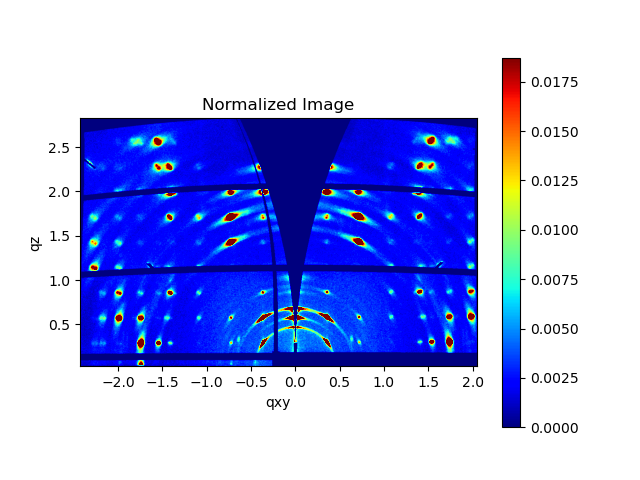

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


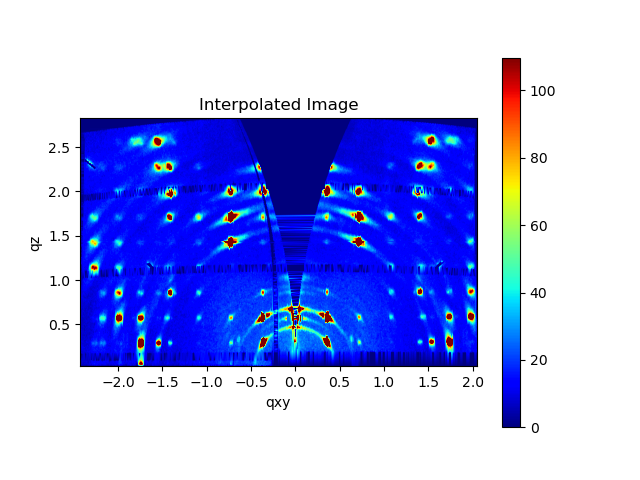

In [8]:
%matplotlib widget

# Handle edge detection
edge_img = waxs_analysis.edge_detection(waxs_analysis.reciptiff_xr, method='canny')  # or 'canny'

# Classify the gaps
gaps = waxs_analysis.classify_gaps(edge_img, tolerance = 20, padding = 1)

# Interpolate gaps
reciptiff_xr_interp = waxs_analysis.interpolate_gaps(waxs_analysis.reciptiff_xr, gaps, threshold=0.1)

# Alternatively, you can use handle_interpolation for a one-step approach
# reciptiff_xr_interp = waxs_analysis.handle_interpolation(method='sobel')

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_interp, 
                            title='Interpolated Image', 
                            cmap='jet')

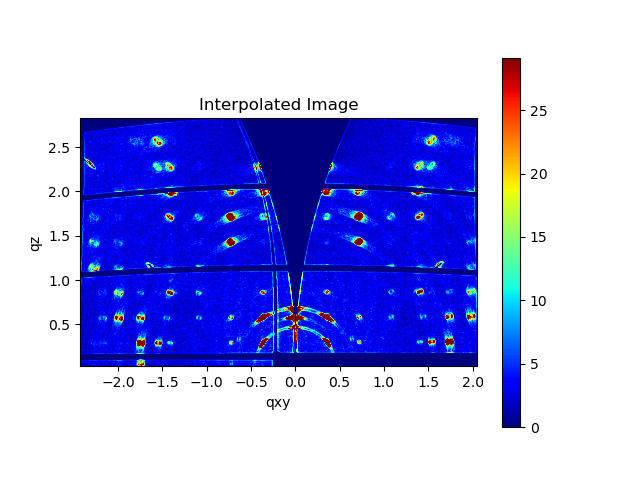

In [ ]:
edge_img = waxs_analysis.edge_detection(waxs_analysis.reciptiff_xr, method='canny')  # or 'canny'

# gaps

waxs_analysis.display_image(edge_img, 
                            title='Interpolated Image', 
                            cmap='jet')

# Define coordinates for plotting based on the original image
# coords = {
#     'x_min': waxs_analysis.reciptiff_xr[waxs_analysis.inplane_config].min(),
#     'x_max': waxs_analysis.reciptiff_xr[waxs_analysis.inplane_config].max(),
#     'y_min': waxs_analysis.reciptiff_xr['q_z'].min(),
#     'y_max': waxs_analysis.reciptiff_xr['q_z'].max()
# }

#### Smoothing Image

In [ ]:
%matplotlib widget

# Smooth the image using the 'smooth_image' method
# smoothed_image = waxs_analysis.smooth_image(waxs_analysis.reciptiff_xr.values, 
#                                             method='gaussian', 
#                                             sigma=.05)

smoothed_image = waxs_analysis.smooth_image(reciptiff_xr_norm, 
                                            method='gaussian', 
                                            sigma=1)
# smoothed_image = waxs_analysis.normalize_image()
# smoothed_image = waxs_analysis.smooth_image(smoothed_image, method='total_variation', sigma=100)

# Display the smoothed image with appropriate coordinates using the 'display_image' method
waxs_analysis.display_image(smoothed_image, 
                            title='Smoothed Image', 
                            cmap='jet')


#### Signal-to-Noise Calculation

In [ ]:
smoothed_image = waxs_analysis.calculate_SNR(smoothed_image)
# waxs_analysis.snrtemp
waxs_analysis.reciptiff_xr.SNR

#### Peak Finder

In [ ]:
# Find peaks using the 'find_peaks' method
waxs_analysis.find_peaks()

### Plotting Methods

##### Raw Data

In [ ]:
%matplotlib widget
waxs_analysis.rawdisplay_xr()
# waxs_analysis.rawtiff_xr

##### Reciprocal Space Map

In [ ]:
%matplotlib widget
waxs_analysis.recipdisplay_xr()
# waxs_analysis.reciptiff_xr

##### Caked Image

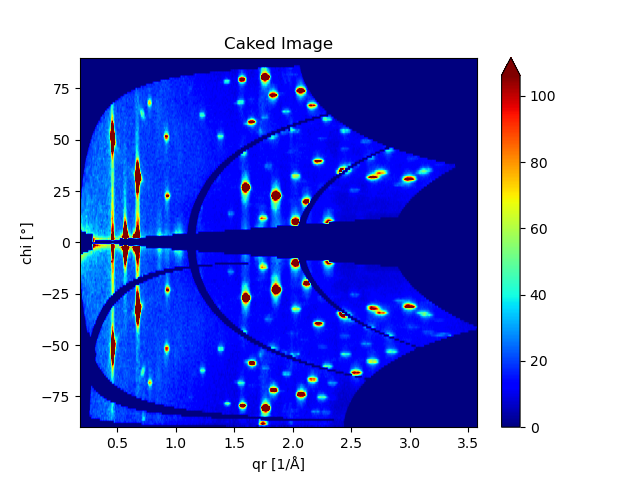

In [6]:
%matplotlib widget
waxs_analysis.cakeddisplay_xr()
# waxs_analysis.cakedtiff_xr

### Load an Existing Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis = WAXSAnalyze(zarrPath = zarrPath, projectName = projectName)

### Export the Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis.exportzarr(zarrPath=zarrPath, projectName=projectName)